In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import null_space
from IPython.display import clear_output
from sklearn.linear_model import LassoLars
import random
import warnings
warnings.filterwarnings('ignore')

Load the dataset

In [2]:
#X = pd.read_csv("../Data/data.csv").drop(['Unnamed: 0'], axis = 1).to_numpy()
#y = pd.read_csv("../Data/labels.csv").drop(['Unnamed: 0'], axis = 1).to_numpy()

In [3]:
#X_proto = X[1:101, 1:201]
#y_proto = y[1:101]

In [4]:
X_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1).drop(['Class'],axis=1).to_numpy()
y_small = pd.read_csv("../Data/BreastTissue.csv").drop(['Case #'],axis = 1)['Class'].to_numpy()

y_small = preprocessing.LabelEncoder().fit_transform(y_small)

In [37]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [45]:
class PCAObject:
    def __init__(self, PCs, X, label):
        assert len(PCs) == min(X.shape[0],X.shape[1]), "Need all the principal components!"
        self.pcs = PCs
        self.X = StandardScaler().fit_transform(X)
        self.cov = np.cov(self.X.T)
        self.label = label
        self.pev, self.cev, self.ev = None, None, None
        self.nonZeroLoads = None
        
    
    def calcExpVar(self):
        tot_var = np.sum(np.diag(self.cov))
        self.ev = np.diag(self.pcs @ np.cov(self.X.T) @ self.pcs.T)/np.linalg.norm(self.pcs, axis = 1)**2
        self.pev = [ev/tot_var for ev in self.ev]
        self.cev = np.cumsum(np.flip(np.sort(self.pev)))
        
    def calcNonZeroLoads(self):
        self.nonZeroLoads = [np.count_nonzero(pc) for pc in self.pcs]
        
    def calcGini(self):
        self.gini = [gini(i) for i in self.pcs]
        
    def calcWgtGini(self):
        self.calcGini()
        self.ExpVar()
        self.wgtGini = [gini * pev for gini, pev in zip(self.gini, self.pev)]
        
    def plotNonZeroLoadtoPEV(self):
        self.calcExpVar()
        self.calcNonZeroLoads()
            
        plt.plot(self.nonZeroLoads, self.pev, label=self.label)
        plt.xlabel('Number of non-zero loadings')
        plt.xscale('log')
        plt.ylabel('Percentage of explained variance (PEV)')
        plt.legend()
        plt.title('Percentage of explained variance (PEV) vs non-zero loadings')
        
    def plotCEV(self):
        self.calcExpVar()
        x = np.arange(len(self.pcs))
        
        plt.plot(x, np.sort(self.cev), label = self.label)
        plt.xlabel('Number of component')
        plt.ylabel('Cumulative explained variance (CEV)')
        plt.legend()
        plt.title('Cumulative explained variance (CEV)')
        
    def plotSparsitytoEV(self,k): #k is which PC you want to plot
        self.calcGini()
        
        plt.scatter(self.gini[k], self.ev[k], label = self.label)
        plt.xlabel('Sparsity of PC '+str(k+1))
        plt.ylabel('Explained Variance of PC '+str(k+1))
        plt.xlim((0,1))
        plt.legend()
        plt.title('Sparsity of PC versus Expained Variance of PC '+str(k+1))

In [6]:
def reg_PCA(X, k = "all"): 
    """
    function takes an n x p feature matrix
    returns two arrays:
    - array with percentage of explained variance in first k principal directions (k_comp x 1)
    - array with principal directions (k_comp x p)
    """
    X = StandardScaler().fit_transform(X)
    if k == "all": k = min(X.shape[0],X.shape[1])
    pca = PCA(n_components = k)
    pca.fit(X)
    PEVs = pca.explained_variance_ratio_
    prin_comp = pca.components_
    EVs = pca.explained_variance_
    
    return PEVs, prin_comp, EVs

In [7]:
def threshold_PCA(X, thresh = 1e-1, k = "all"):
    """
    function takes
    - X: n x p feature matrix
    - thresh: float representing this non-zero cutoff
    - k: integer for number of principal directions wanted
    returns one array:
    - array with principal components in its columns (k x p)
    """
    if k == "all": k = min(X.shape[0],X.shape[1])

    pcs = reg_PCA(X)[1]
    pcs = (np.abs(pcs) >= thresh).astype(int) * pcs
    
    return pcs[:k]

In [8]:
def nonZeroLoad_PCA(X,j, k = "max"):
    """
    function takes
    - X: n x p feature matrix
    - j: integer for number of non-zero loadings,
    - k: integer for number of principal directions wanted
    returns three arrays:
    - array with percentages of explained variance in first k principal directions (k x 1)
    - array with principal directions (k x p)
    - array with explained variances
    """   
    X_scaled = StandardScaler().fit_transform(X)
    if k == "all": k = min(X.shape[0],X.shape[1])
    
    PCA_PEV, PCA_PC, PCA_EV = reg_PCA(X,min(X.shape[0],X.shape[1]))
    
    total_var = sum(PCA_EV)
    
    thresh_PCA_PC = np.empty((0,PCA_PC.shape[1]))
    thresh_PCA_PEV = []
    thresh_PCA_EV = []
    
    PCA_PC_sorted = np.sort(np.absolute(PCA_PC), axis = 1)
    for m in range(k):
        thresh = PCA_PC_sorted[m][-j]
        thresh_PC = (np.absolute(PCA_PC[m]) >= thresh).astype(int)*PCA_PC[m]
        thresh_PCA_PC = np.vstack((thresh_PCA_PC, thresh_PC))
    
    return thresh_PCA_PC

In [9]:
def SimpTrans(r, s, k, X_scaled):
    """
    function takes
    - Two directions r and s to transform
    - An integer k that restricts the possible directions
    - The scaled data matrix X
    returns two vectors and three floats
    - Two new directions r and s
    - Two floats representing the variances explained by the new directions r and s
    - One float representing the covariance of the new directions r and s
    """
    # Calculate the covariance matrix for the two directions
    cov = np.vstack((r,s)) @ np.cov(X_scaled.T) @ np.vstack((r,s)).T
    v_old_r, v_old_s, v_old_rs = cov[0,0], cov[1,1], cov[0,1]
    
    # Get a list of all possible betas
    poss_beta1 = [i/2**k for i in range(-2**k, 2**k+1, 1)]
    poss_beta2 = [2**k/i for i in range(-2**k, 2**k+1, 1) if i != 0]
    poss_beta = np.sort(list(set(poss_beta1 + poss_beta2)))
    
    # Calculate the norms of the two directions
    l2_r, l2_s = np.linalg.norm(r)**2, np.linalg.norm(s)**2
    
    # Find the beta that maximizes the variance in the normalized
    # direction of the first new principal component
    v_r, v_s, v_rs = cov[0,0], cov[1,1], cov[0,1]
    a = l2_s*v_rs
    b = np.sqrt(l2_r*l2_s)*(v_r - v_s)
    c = l2_r*v_rs
    discr = b**2 - 4*a*c
    beta_star = (-b+np.sqrt(discr))/(2*a)
    
    # Select beta from possible values that's closest to the optimal value
    beta_star = min(list(poss_beta), 
                    key = lambda x:abs(x-beta_star))
    
    # Calculate the two new directions
    if abs(beta_star) <= 1:
        r_new = 2**k*r + 2**k*beta_star*s
        s_new = 2**k*beta_star*l2_s*r - 2**k*l2_r*s
    else:
        r_new = 2**k*r/beta_star + 2**k*s
        s_new = 2**k*l2_s*r - 2**k*l2_r*s/beta_star
    
    # Calculate variances and covariance of the new directions
    P = np.array([[1, l2_s*beta_star],[beta_star, -l2_r]])
    cov_new = P.T @ cov @ P
    v_r, v_s, v_rs = cov_new[0,0], cov_new[1,1], cov_new[0,1]
    
    return r_new, s_new, v_r, v_s, v_rs

In [10]:
def pcPairFinder(cov, cache):
    """
    function takes
    - A covariance matrix
    - A cache containing the indices of excluded pcs
    returns two integers:
    - i_r: the index of the first principal component
    - i_s: the index of the second principal component
    """
    # Turn covariance matrix into a sparse lower triangular matrix
    grid = np.tril(cov, k = -1)
    vrs = np.diag(cov)
    # Flatten the grid and sort from largest cov to smallest cov
    srt = np.sort(np.ravel(grid), kind = 'heapsort')
    lst = list(np.flip(np.trim_zeros(srt)))
    mask = False
    
    # Find the pair of pcs that are not already in the cache and hav
    # the highest covariance in the grid
    while not np.any(mask):
        covar = lst.pop(0)
        index = np.argwhere(grid == covar)
        mask = np.ravel(np.invert(np.any(np.isin(index, cache), axis = 1, keepdims = True)))

    # Unpack the indices make sure that the variance of r is larger than the variance of s
    index = index[mask,:][0]
    i_r = index[np.argmax([vrs[i] for i in index])]
    i_s = index[np.argmin([vrs[i] for i in index])]
    return i_r, i_s

In [11]:
def simple_PCA(X, k, iters = 1):
    """
    function takes
    - An unscaled data matrix X
    - An integer k that restricts the possible directions
    - An integer indicating the number of iterations
    returns one array:
    - array with principal components in its columns (k x p)
    """
    # Retrieve the principal components and their covariance matrix
    n_obs, n_feats = X.shape
    q = np.identity(n_obs)
    for _ in range(n_feats//n_obs):
        q = np.hstack((q,np.identity(n_obs)))
    pcs = q[:n_obs,:n_feats]
    
    cov = np.cov(X.T)
    X_scaled = StandardScaler().fit_transform(X)
    
    # Setup up globals for loop
    cov_pc = pcs @ cov @ pcs.T
    cache = []
    
    for _ in range(iters):
        while len(cache) <= len(pcs) - 2:
            clear_output(wait = True)
            print("Working on principal component ", len(cache) + 2,"/",len(pcs))
            
            # Find set of principal components to transform
            i_r, i_s = pcPairFinder(cov_pc, cache)
            r, s = pcs[i_r], pcs[i_s]
            cache += [i_r, i_s]
            
            # Transform the pair of components
            print("Determining new directions...")
            r_new, s_new, v_r, v_s, v_rs = SimpTrans(r, s, k, X_scaled)

            # Update the principal components
            pcs[i_r] = r_new
            pcs[i_s] = s_new
            
            # Update the grid matrix
            cov_pc[i_s, i_r], cov_pc[i_r, i_s] = v_rs, v_rs
    
    return pcs

In [12]:
def scotlass_pen(x, gamma):
    '''
    regularization penalty function for SCoTLASS
    
    function takes 
    - x: float
    - gamma: float
    
    function returns 
    - penalty value: float
    '''
    return (0.5 * x) * (1 + np.tanh(gamma*x))

def scotlass_obj(sigma, v, reg_param, gamma):
    '''
    objective function for SCoTLASS
    
    function takes
    - sigma: p x p covariance matrix
    - v: p x 1 vector
    - reg_param: regularization parameter (positive float)
    - gamma: float
    
    function returns
    - objective function value at v (p x 1 vector)
    '''
    varimax = (0.5*v.T) @ sigma @ v
    argpen = v.T @ np.tanh(1000*v)-reg_param
    penalty = gamma * scotlass_pen(argpen, gamma)
    return np.array(varimax - penalty).flatten()

def scotlass_grad(sigma, v, reg_param, gamma):
    '''
    gradient of objective function for SCoTLASS
    
    function takes
    - sigma: p x p covariance matrix
    - v: p x 1 vector
    - reg_param: regularization parameter (positive float)
    - gamma: float
    
    function returns
    - gradient of objective function at v
    '''
    # Setup of parameters
    mu = 1000
    
    # Calculate floats
    y = (v.T @ np.tanh(gamma*v))-reg_param
    q = 1 + np.tanh(gamma*y) + gamma*np.cosh(gamma*y)**(-2)*y
    
    # Calculate vectors
    z = np.tanh(gamma*v) + gamma * (np.diag(np.ravel(np.cosh(gamma*v)**(-2))) @ v)
    
    return (sigma @ v) - 0.5*mu*q*z 

In [13]:
def scotlassGradAsc(sigma, V, reg_param , x0 = 'default', 
                    alpha = 10**-3, max_iter = 20000, crit = 1e-1000):
    '''
    function takes
    - sigma: p x p covariance matrix
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - v: first sparse principal direction (array of length p)
    - variance of data along v
    '''
    # Configure the parameters
    iters, delta, gamma = 1, 1, 1000
    num_obs, num_feat = sigma.shape
    
    # Configure the regularization parameter
#     reg_error = '''
#     The regularization parameter needs to be smaller than 
#     the square root of the number of features in the dataset.
#     '''
#     if reg_param == 'default': reg_param = np.sqrt(num_feat)
#     else: assert reg_param <= np.sqrt(num_feat), reg_error
    
    # Initialize the algorithm
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    # Projected gradient descent
    # Stopping criteria:
    # (1) Maximum iterations reached
    # (2) Change in objective function negligible
    while iters < max_iter and delta > crit:
        
        # Update the vector
        v_new = v + alpha*scotlass_grad(sigma, v, reg_param, gamma)
        
        # Project loading vector back onto feasible set 
        # (vectors of l2 norm of 1 that are orthogonal to all other pcs)
        v_proj = V @ v_new
        v_proj = v_proj/(np.linalg.norm(v_proj))
        
        # Use the projected loading vector to retrieve the value of the
        # objective function
        old_obj = scotlass_obj(sigma, v, reg_param, gamma)[0]
        updated_obj = scotlass_obj(sigma, v_proj, reg_param, gamma)[0]

        # Calculate the difference in value of the objective function
        delta = [updated_obj - old_obj][0]
        #print(delta)
        # Update vector and number of iterations
        v, iters = v_proj, iters + 1
    
    # return loadings array v
    print('finished pc')
    return v

In [14]:
def SCoTLASS(X, reg_param, x0 = 'default', alpha = 10**-3,
             max_iter = 20000, crit = 1e-1000):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - array with principal components in its columns (n x p)
    '''
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    sigma = np.cov(X.T)
    num_feat = X.shape[1]
    num_samp = X.shape[0]
    
    # Initialize an array for principal components
    pcs = np.zeros(shape = (min(X.shape[0],X.shape[1]),X.shape[1]))
    
    # Initialize projection vector V
    V = np.identity(num_feat)
    
    for _ in range(len(pcs)):
        # Find the best principal component
        pc = scotlassGradAsc(sigma, V, reg_param, x0, alpha, max_iter, crit)
        pcs[_] = pc.T
        
        # Project the covariance matrix and x0 
        # on the orthogonal complement of previous pcs
        V = null_space(pcs[:_+1]) @ null_space(pcs[:_+1]).T
        sigma = V @ sigma
        x0 = V @ np.ones(shape = (num_feat,1))
    return pcs

For $B\in \mathbb{R}^{p\times m}$:
$$
Varimax(B) = \frac{1}{p^2}\sum_{k=1}^m\left[\underbrace{m\sum_{j=1}^p b_{jk}^4}_{P} - \underbrace{\left(\sum_{j=1}^p b_{jk}^2\right)^2}_{Q}\right]
$$

In [15]:
def varimax(x):
    '''
    varimax penalty function
    
    function takes 1 x p vector
    
    function returns float
    '''
    #     p, m = B[None,:].shape
    #     P = m*np.sum(np.power(B, 4), axis = 0)
    #     Q = np.power(np.sum(np.power(B, 2), axis = 0), 2)
    #     return 1/p**2 * np.sum(P - Q)
    
    p = len(x)
    varimax = np.sum(np.power(x, 4))
    varimax -= (x.T @ x)[0]**2
    varimax = varimax/(p**2)
    
    return varimax

def varimax_grad(x):
    '''
    varimax penalty function gradient
    
    function takes 1 x p vector
    
    function returns 1 x p varimax gradient vector'''
    p = len(x)
    grad = 4*(np.power(x, 3) - (x.T @ x)* x)/(p**2)
    
    return grad

def scot_obj(sigma, v, reg_param):
    '''
    SCoT objective function
    
    function takes
    - sigma: p x p covariance matrix
    - v: 1 x p vector
    - reg_param: varimax regularization parameter (positive float)
    
    function returns float
    '''
    obj = v.T @ sigma @ v + (reg_param*varimax(v))[0]

    return obj

def scot_obj_grad(sigma, v, reg_param):
    '''
    SCoT objective function gradient
    
    function takes
    - sigma: p x p covariance matrix
    - v: 1 x p vector
    - reg_param: varimax regularization parameter (positive float)
    
    function returns 1 x p gradient vector
    '''
    
    p = len(v)
    grad = np.array((sigma @ v)) + reg_param*varimax_grad(v)
    return grad

In [16]:
def scotGradAsc(sigma, V, reg_param, x0 = 'default', 
                    alpha = 10**-3, max_iter = 20000, crit = 1e-1000):
    '''
    function takes
    - sigma: p x p covariance matrix
    - reg_param: regularization parameter (positive float); Default = sqrt(p)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - v: first sparse principal direction (array of length p)
    - variance of data along v
    '''
    # Configure the parameters
    iters, delta, gamma = 1, 1, 1000
    num_obs, num_feat = sigma.shape
    
    # Initialize the algorithm
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    # Projected gradient descent
    # Stopping criteria:
    # (1) Maximum iterations reached
    # (2) Change in objective function negligible
    while iters < max_iter and delta > crit:
        
        # Update the vector
        v_new = v + alpha*scot_obj_grad(sigma, v, reg_param)
        
        # Project loading vector back onto feasible set 
        # (vectors of l2 norm of 1 that are orthogonal to all other pcs)
        v_proj = V @ v_new
        v_proj = v_proj/(np.linalg.norm(v_proj))
        
        # Use the projected loading vector to retrieve the value of the
        # objective function
        old_obj = scot_obj(sigma, v, reg_param)[0]
        updated_obj = scot_obj(sigma, v_proj, reg_param)[0]

        # Calculate the difference in value of the objective function
        delta = [updated_obj - old_obj][0]
        
        # Update vector and number of iterations
        v, iters = v_proj, iters + 1
    
    # return loadings array v
    return v

In [17]:
def SCoT(X, reg_param, x0 = 'default', alpha = 10**-3,
             max_iter = 20000
         
         , crit = 1e-1000):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    function returns
    
    - array with principal components in its columns (n x p)
    '''
    # Standardize the dataset
    X = StandardScaler().fit_transform(X)
    sigma = np.cov(X.T)
    num_feat = sigma.shape[0]
    
    # Initialize an array for principal components
    pcs = np.zeros(shape = (min(X.shape[0],X.shape[1]),X.shape[1]))
    
    # Initial vector for gradient descent
    if x0 == 'default': x0 = np.ones(shape = (num_feat,1))
    elif x0 == 'random': x0 = np.random.rand(num_feat,1)
    else: pass
    v = x0/np.linalg.norm(x0)
    
    V = np.identity(X.shape[1])
    
    for _ in range(len(pcs)):
        # Find the best principal component
        pc = scotGradAsc(sigma, V, reg_param, x0, alpha, max_iter, crit)
        pcs[_] = pc.T
        
        # Project the covariance matrix and x0 
        # on the orthogonal complement of previous pcs
        V = null_space(pcs[:_+1]) @ null_space(pcs[:_+1]).T
        sigma = V @ sigma
        x0 = V @ np.ones(shape = (num_feat,1))
        x0 = x0/np.linalg.norm(x0)
        
    return pcs

In [18]:
def SVDProblem(B, X):
    '''
    function takes
    - X: n x p dataset
    - B: p x n matrix
    
    function returns
    - A: p x n matrix
    '''
    U, D, V = np.linalg.svd(X.T @ X @ B)
    return U @ V.T

In [34]:
def SPCA(X, reg_param, reg_param1, max_iter = 1000, crit = 1e-10):
    '''
    function takes
    - X: n x p dataset
    - reg_param: regularization parameter (positive float)
    - x0: Initial value of the vector
    - alpha: Step size of gradient descent (<1 for convergence)
    - max_iters: max number of steps (positive integer)
    - crit: critical stopping value for the gradient descent algorithm
    
    function returns
    - array with principal components in its columns (n x p)
    '''
    # (1) Let A start at V[,1:k] the loadings of the first 
    # k ordinary principal components
    A = reg_PCA(X)[1].T
    B = np.zeros_like(A)
    
    # Normalize the dataset
    X = StandardScaler().fit_transform(X)
    
    iters, delta, A_old = 1, 1, A
    while iters < max_iter and delta > crit:
        # (2) Given a fixed A = [alpha_1, ..., alpha_k], solve the elastic
        # net problem for j = 1, 2, ..., k
        for i in range(len(A)):
            #print(f"{iters}: PC {i}")
            B[i] = LARS_EN(X @ A[i].reshape(-1,1), # Target variable
                           X,                      # Data
                           reg_param,              # l2-norm reg param
                           reg_param1)             # l1-norm reg param
        
        # (3) For a fixed B = [beta_1, ..., beta_k], compute the SVD of 
        # X^TXB = UDV^T then update A = UV^T
        A = SVDProblem(B, X)
        
        # (4) Repeat steps (2) and (3) until convergence
        iters, delta, A_old = iters + 1, np.linalg.norm(A - A_old), A
        print(f"{iters} delta: {delta}")
    
    # (5) Normalize the altered principal components
    return (A/np.linalg.norm(A, axis = 1)).T

Step 2 (B given A):
$$
\hat{\beta}_j = argmin_{\beta_j} \|Y_j - X\beta_j\|^2 + \lambda\|\beta_j\|^2 + \lambda_{1,j}\|\beta_j\|_1
$$
with $Y_j = X\alpha_j$. We can rewrite this as
$$
\hat{\beta}^* = argmin_{\beta^*} \|Y^*_j - X^*\beta^*\|^2 + \gamma\|\beta^*\|_1
$$
with
$$
X^* = (1 + \lambda)^{-1/2}\begin{pmatrix}X\\\sqrt{\lambda I}\end{pmatrix}\in\mathbb{R}^{(n+p)\times p},\qquad Y^* = \begin{pmatrix}Y\\0\end{pmatrix}\in\mathbb{R}^{n+p}
$$
and
$$
\gamma = \frac{\lambda_{1,j}}{\sqrt{1+\lambda}}
$$
From $\beta^*$ we can find $\hat{\beta_j}$:
$$
\hat{\beta}=\frac{1}{\sqrt{1+\lambda}}\hat{\beta}^*
$$

In [35]:
def LARS_EN(Y, X, reg_param, reg_param1):
    '''
    function takes
    - Y: p x 1 target variable
    - X: n x p dataset
    - reg_param: regularization parameter for l2-norm
    - reg_param1: regularization parameter for l1-norm
    
    function returns
    - beta: 1 x p vector with coefficients
    '''
    # Find the number of features
    p = X.shape[1]
    
    # Create the artificial dataset for the naïve elastic net
    X = np.power(1 + reg_param, -0.5) * np.vstack((X, np.sqrt(reg_param)*np.identity(p)))
    Y = np.vstack((Y, np.zeros(shape = (p,1))))
    gamma = reg_param1/np.sqrt(1 + reg_param)
    
    # Use the LARS (Efron 2004) algorithm to solve this lasso regression
    lasso = LassoLars(alpha = gamma,
                      fit_intercept = False,
                      normalize = False,
                      max_iter = 1000)
    lasso.fit(X, Y)
    
    # Transform the found coefficients in the elastic net coefficients
    beta = lasso.coef_/(1 + reg_param)
    
    return beta

In [46]:
reg_SPCA = PCAObject(SPCA(X_small, 1, 1), X_small, "SPCA")

2 delta: 4.024048807915733
3 delta: 4.529430647480266
4 delta: 4.544765910052904
5 delta: 3.7803411245993797
6 delta: 3.7289038213528136
7 delta: 4.1394911587186884
8 delta: 4.385633798125351
9 delta: 4.209563593246686
10 delta: 4.565285125188452
11 delta: 4.366660544171491
12 delta: 4.189031255696298
13 delta: 3.9105312245975425
14 delta: 4.540479774978476
15 delta: 4.342839945109263
16 delta: 3.831121436708665
17 delta: 4.237262453260092
18 delta: 4.212919086285411
19 delta: 4.0843952327399276
20 delta: 3.7675889773202966
21 delta: 4.381030853938124
22 delta: 3.882684657425011
23 delta: 4.2228968858165015
24 delta: 4.411581698203431
25 delta: 4.352928212296273
26 delta: 4.374434225374116
27 delta: 4.765788487446304
28 delta: 4.5232135439012575
29 delta: 4.736539092763754
30 delta: 4.530759034172283
31 delta: 3.0202357644948723
32 delta: 3.1381113622312613
33 delta: 4.291937824015021
34 delta: 3.829414512639473
35 delta: 4.670295012831741
36 delta: 4.237419754402706
37 delta: 4.193491

305 delta: 4.387431196433929
306 delta: 4.310863627270554
307 delta: 3.690154887069558
308 delta: 4.3010883493260685
309 delta: 4.274893545271226
310 delta: 3.7884723020116846
311 delta: 3.9459484051923455
312 delta: 4.474208179893399
313 delta: 4.78970046762572
314 delta: 4.241767899965434
315 delta: 4.475195685705454
316 delta: 4.425955313675124
317 delta: 3.8170227780465207
318 delta: 4.3799085637672786
319 delta: 4.5267470883756635
320 delta: 4.0271923576480315
321 delta: 4.211931888527775
322 delta: 4.403073470051892
323 delta: 4.226240634619792
324 delta: 4.250423065173401
325 delta: 4.63131051603374
326 delta: 4.0942032998725635
327 delta: 4.227621424116653
328 delta: 4.605230110600642
329 delta: 4.44351333445016
330 delta: 4.389692077696749
331 delta: 4.080698016312513
332 delta: 4.182136712571156
333 delta: 4.262346690019174
334 delta: 4.13179589522412
335 delta: 2.6667539410970793
336 delta: 2.683034567053035
337 delta: 4.359705568810285
338 delta: 4.332940508350608
339 delta

606 delta: 4.483028079825817
607 delta: 4.307991925687221
608 delta: 3.741871024567405
609 delta: 4.3693982300725365
610 delta: 4.370284463536637
611 delta: 4.125392892347172
612 delta: 4.416042483051546
613 delta: 4.49008312373695
614 delta: 4.59815705769378
615 delta: 4.040156599741131
616 delta: 4.157092179104595
617 delta: 4.004599832028903
618 delta: 4.47165466851841
619 delta: 3.943020718767164
620 delta: 4.18311765335115
621 delta: 4.233386533582531
622 delta: 3.9658477518275297
623 delta: 4.088444921474914
624 delta: 4.735655868665438
625 delta: 3.719513550461171
626 delta: 4.328523071281671
627 delta: 4.413938696393507
628 delta: 4.10927417472017
629 delta: 4.36308934461697
630 delta: 4.435350778837808
631 delta: 4.526156192785602
632 delta: 4.205973487728213
633 delta: 4.3103034215263385
634 delta: 4.634893712246133
635 delta: 4.3447220147137475
636 delta: 4.228410282224691
637 delta: 4.232747887784688
638 delta: 4.035585284852706
639 delta: 4.02631823193658
640 delta: 4.2013

899 delta: 4.261709871279097
900 delta: 4.006058726289074
901 delta: 3.9508438906519103
902 delta: 4.314296103873547
903 delta: 4.5184911590396375
904 delta: 4.100897972435204
905 delta: 4.373832014805483
906 delta: 3.9205212465904506
907 delta: 4.285332784531999
908 delta: 4.198140846625497
909 delta: 4.434579515069617
910 delta: 4.5204458723415755
911 delta: 4.335798563245095
912 delta: 3.475533447462437
913 delta: 4.269502974046306
914 delta: 3.430210545556727
915 delta: 4.346342177882166
916 delta: 2.0006212863721506
917 delta: 2.4930019606120077
918 delta: 3.9724177555293503
919 delta: 4.449912932909372
920 delta: 4.127803297289824
921 delta: 4.435473623894751
922 delta: 4.163838734146917
923 delta: 4.138727169832607
924 delta: 4.368366019350649
925 delta: 4.068270321419991
926 delta: 3.8879139618667997
927 delta: 4.2129634644577765
928 delta: 4.046201898334282
929 delta: 4.358168934651928
930 delta: 4.42193067478255
931 delta: 4.224855339785444
932 delta: 4.031126823686627
933 de

In [47]:
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")

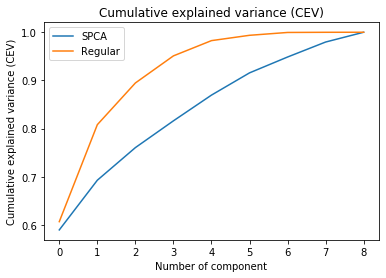

In [48]:
reg_SPCA.plotCEV()
reg_reg.plotCEV()
reg_scotlass_1.plotCEV()

In [ ]:
# MAKE SURE TO PROPERLY TUNE STEP SIZE TO REG_PARAM!!!!!
# MAKE SURE TO PROPERLY TUNE STEP SIZE TO REG_PARAM!!!!!
# MAKE SURE TO PROPERLY TUNE STEP SIZE TO REG_PARAM!!!!!

reg_thresh = PCAObject(threshold_PCA(X_small), X_small, "Thresh")
reg_reg = PCAObject(reg_PCA(X_small)[1], X_small, "Regular")
reg_scot_100 = PCAObject(SCoT(X_small, 100, alpha = 10**-3), X_small, "SCoT 100")
reg_scot_500 = PCAObject(SCoT(X_sxmall, 500, alpha = 10**-3), X_small, "SCoT 500")
reg_scotlass_1 = PCAObject(SCoTLASS(X_small,1,alpha = 10**-6, ), X_small, "SCoTLASS 1")
reg_scotlass_2 = PCAObject(SCoTLASS(X_small,2,alpha = 10**-5, max_iter=50000), X_small, "SCoTLASS 2")
reg_scotlass_2pt5= PCAObject(SCoTLASS(X_small,2.5,alpha = 10**-5, max_iter=50000), X_small, "SCoTLASS 2.5")
reg_scotlass_4 = PCAObject(SCoTLASS(X_small, 4,alpha = 10**-3), X_small, "SCoTLASS 4")

In [ ]:
reg_scotlass_1pt5= PCAObject(SCoTLASS(X_small,1.5,alpha = 10**-6, max_iter=100000), X_small, "SCoTLASS 1.5")

In [ ]:
reg_scotlass_1pt6= PCAObject(SCoTLASS(X_small,1.6,alpha = 2*10**-6, max_iter=100000), X_small, "SCoTLASS 1.6")

In [ ]:
reg_scotlass_1pt7= PCAObject(SCoTLASS(X_small,1.7,alpha = 4*10**-6, max_iter=100000), X_small, "SCoTLASS 1.7")

In [ ]:
reg_scotlass_1pt8= PCAObject(SCoTLASS(X_small,1.8,alpha = 5*10**-6, max_iter=100000), X_small, "SCoTLASS 1.8")

In [ ]:
reg_thresh.plotCEV()
reg_reg.plotCEV()
reg_scot_100.plotCEV()
reg_scot_500.plotCEV()
reg_scotlass_2.plotCEV()
reg_scotlass_4.plotCEV()

In [ ]:
reg_reg.calcExpVar()
reg_scot_100.calcExpVar()
reg_scot_500.calcExpVar()
reg_scotlass_1.calcExpVar()
reg_scotlass_1pt5.calcExpVar()
reg_scotlass_1pt6.calcExpVar()
reg_scotlass_1pt7.calcExpVar()
reg_scotlass_1pt8.calcExpVar()
reg_scotlass_2.calcExpVar()
reg_scotlass_2pt5.calcExpVar()

reg_reg.plotSparsitytoEV(0)
reg_scotlass_1.plotSparsitytoEV(0)
reg_scotlass_1pt5.plotSparsitytoEV(0)
reg_scotlass_1pt6.plotSparsitytoEV(0)
reg_scotlass_1pt7.plotSparsitytoEV(0)
reg_scotlass_1pt8.plotSparsitytoEV(0)

In [ ]:
x = np.arange(len(reg_reg.pcs))

vm_reg = np.apply_along_axis(varimax, axis = 1, arr = reg_reg.pcs)
vm_scot = np.apply_along_axis(varimax, axis = 1, arr = reg_scot.pcs)

plt.plot(x, vm_reg, label = "regular")
plt.plot(x, vm_scot, label = "SCoT")
plt.xlabel('Number of component')
plt.ylabel('Varimax criterion')
plt.legend()
plt.title(' ')

In [ ]:
plt.hist(reg_scotlass_1pt8.pcs[0])

In [ ]:
np.sum(np.apply_along_axis(varimax, axis = 1, arr = reg_scotlass_14.pcs))

In [ ]:
np.sum(np.apply_along_axis(varimax, axis = 1, arr = reg_scot.pcs))

In [ ]:
# def gini(x):
#     # (Warning: This is a concise implementation, but it is O(n**2)
#     # in time and memory, where n = len(x).  *Don't* pass in huge
#     # samples!)

#     # Mean absolute difference
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     # Relative mean absolute difference
#     rmad = mad/np.mean(x)
#     # Gini coefficient
#     g = 0.5 * rmad
#     return g

# gini coefficient method from Olivia Guest: https://github.com/oliviaguest/gini